In [59]:
import numpy as np
import pandas as pd
from pathlib import Path

In [60]:
dataset_root = 'data'

In [69]:
# go one folder up, then down to data folder
data_path = Path.cwd().parent / dataset_root
df = pd.read_csv(data_path / 'database.csv')


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [68]:
from geopy.distance import geodesic
from sklearn.cluster import KMeans

def calculate_distance(current_lat, current_lon, prev_lat, prev_lon):
    # Check if any value is missing (e.g., for the first row)
    if pd.isnull(prev_lat) or pd.isnull(prev_lon):
        return 0  # No distance for the first row
    # Calculate geodesic distance
    return geodesic((current_lat, current_lon), (prev_lat, prev_lon)).km


def preprocess(data):
    data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format="%m/%d/%Y %H:%M:%S", errors='coerce')
    data = data[data['Timestamp'] >= pd.Timestamp('1970-01-01')]

    data.reset_index(drop=True, inplace=True)
    data = data.drop(['Date', 'Time'], axis=1)

    data['Time_Delta'] = data['Timestamp'].diff().dt.total_seconds()    
    data = data.fillna(0)
    data['Year'] = data['Timestamp'].dt.year
    data['Month'] = data['Timestamp'].dt.month
    data['Day'] = data['Timestamp'].dt.day
    data['Weekday'] = data['Timestamp'].dt.weekday
    data['Hour'] = data['Timestamp'].dt.hour

    data['Hour'] = data['Timestamp'].dt.hour
    data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

    data['DayOfYear'] = data['Timestamp'].dt.dayofyear
    data['DayOfYear_Sin'] = np.sin(2 * np.pi * data['DayOfYear'] / 365)
    data['DayOfYear_Cos'] = np.cos(2 * np.pi * data['DayOfYear'] / 365)

    data['Month_Sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Month_Cos'] = np.cos(2 * np.pi * data['Month'] / 12)

    data['Day_Sin'] = np.sin(2 * np.pi * data['Day'] / 31)
    data['Day_Cos'] = np.cos(2 * np.pi * data['Day'] / 31)


    
    # Create shifted columns for previous latitude and longitude
    data['Prev_Latitude'] = data['Latitude'].shift(1)
    data['Prev_Longitude'] = data['Longitude'].shift(1)
    
    # Compute geodesic distance using the fixed function
    data['Geodesic_Distance'] = data.apply(
        lambda row: calculate_distance(row['Latitude'], row['Longitude'], 
                                       row['Prev_Latitude'], row['Prev_Longitude']), 
        axis=1
    )
    
    # Drop temporary columns if needed
    data = data.drop(columns=['Prev_Latitude', 'Prev_Longitude'])
 
    kmeans = KMeans(n_clusters=10, random_state=42)
    data['Region_Cluster'] = kmeans.fit_predict(data[['Latitude', 'Longitude']])

    data['Cumulative_Magnitude'] = data['Magnitude'].rolling(window=5).sum()
    data['Avg_Magnitude'] = data['Magnitude'].rolling(window=5).mean()

    global_avg_magnitude = data['Magnitude'].mean()
    data['Deviation_From_Avg'] = data['Magnitude'] - global_avg_magnitude

    data['Magnitude_Lag1'] = data['Magnitude'].shift(1)
    data['Time_Delta_Lag1'] = data['Time_Delta'].shift(1)

    data['Magnitude_Depth'] = data['Magnitude'] * data['Depth']
    data['Region_Time'] = data['Region_Cluster'] * data['Time_Delta']

    data['Rolling_Magnitude_Month'] = data['Magnitude'].rolling(window=30).mean()
    data['Year_Count'] = data.groupby('Year')['Magnitude'].transform('count')

    data['Yearly_Avg_Magnitude'] = data.groupby('Year')['Magnitude'].transform('mean')
    data['Cumulative_Quakes'] = np.arange(1, len(data) + 1)  # Simple cumulative count
    data['Magnitude_Year'] = data['Year'] * data['Magnitude']
    data['Depth_Month'] = data['Depth'] * data['Month']

 
    return data

In [70]:
df = preprocess(df)

C:\Users\Aryan Wadhawan\AppData\Local\Temp\ipykernel_34272\1507896547.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format="%m/%d/%Y %H:%M:%S", errors='coerce')


In [75]:
df.shape

(21953, 35)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21953 entries, 0 to 21952
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Latitude   21953 non-null  float64       
 1   Longitude  21953 non-null  float64       
 2   Depth      21953 non-null  float64       
 3   Magnitude  21953 non-null  float64       
 4   Timestamp  21953 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 857.7 KB


In [35]:
# max and min magnitudes
df['Magnitude'].value_counts()

Magnitude
5.50    4655
5.60    3769
5.70    2847
5.80    2164
5.90    1807
        ... 
5.88       1
8.80       1
5.72       1
6.02       1
5.73       1
Name: count, Length: 61, dtype: int64

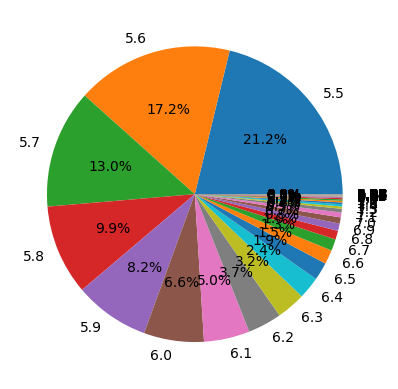

In [36]:
import matplotlib.pyplot as plt

plt.pie(df['Magnitude'].value_counts(), labels=df['Magnitude'].value_counts().index, autopct='%1.1f%%')
plt.show()

In [38]:
df.isna().sum()

Latitude     0
Longitude    0
Depth        0
Magnitude    0
Timestamp    0
dtype: int64

In [ ]:
# time delta statistics
time_deltas = (df['Timestamp'] - df['Timestamp'].shift()).dropna()
print(f"avg delta: {time_deltas.mean()}")
print(f"max delta: {time_deltas.max()}")
print(f"min delta: {time_deltas.min()}")

avg delta: 0 days 18:45:59.522959183
max delta: 10 days 00:11:20
min delta: 0 days 00:00:00


In [45]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21953 entries, 0 to 21952
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Latitude   21953 non-null  float64       
 1   Longitude  21953 non-null  float64       
 2   Depth      21953 non-null  float64       
 3   Magnitude  21953 non-null  float64       
 4   Timestamp  21953 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4)
memory usage: 857.7 KB


,Latitude,Longitude,Depth,Magnitude,Timestamp
0,-29.400,-177.169,35.0,5.6,1970-01-01 17:11:00
1,24.185,102.543,11.3,7.1,1970-01-04 17:00:41
2,23.984,102.732,15.0,5.9,1970-01-05 11:49:10
3,-9.583,151.493,15.0,6.3,1970-01-06 05:35:54
4,15.785,-59.808,36.7,6.0,1970-01-07 07:56:14


In [52]:
df = df.sort_values(by='Timestamp', ascending=True)

In [53]:
df['Time_Delta'] = df['Timestamp'].diff().dt.total_seconds()

In [55]:
df = df.fillna(0)

,Latitude,Longitude,Depth,Magnitude,Timestamp,Time_Delta
0,-29.4000,-177.1690,35.00,5.6,1970-01-01 17:11:00,0.0
1,24.1850,102.5430,11.30,7.1,1970-01-04 17:00:41,258581.0
2,23.9840,102.7320,15.00,5.9,1970-01-05 11:49:10,67709.0
3,-9.5830,151.4930,15.00,6.3,1970-01-06 05:35:54,64004.0
4,15.7850,-59.8080,36.70,6.0,1970-01-07 07:56:14,94820.0
...,...,...,...,...,...,...
21948,38.3917,-118.8941,12.30,5.6,2016-12-28 08:22:12,251.0
21949,38.3777,-118.8957,8.80,5.5,2016-12-28 09:13:47,3095.0
21950,36.9179,140.4262,10.00,5.9,2016-12-28 12:38:51,12304.0
21951,-9.0283,118.6639,79.00,6.3,2016-12-29 22:30:19,121888.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(LSTMWithAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim, 1)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_dim)
        
        # Compute attention scores
        attention_weights = torch.tanh(self.attention(lstm_out))  # (batch_size, seq_length, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)  # Normalize along sequence length
        
        # Apply attention weights
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_dim)
        
        # Pass through fully connected layer
        output = self.fc(self.dropout(context_vector))  # (batch_size, output_dim)
        return output
